In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
    Source: opencv.org
    grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:    rgb
    (tensor): rgb image
    Return:(tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


In [3]:
#load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


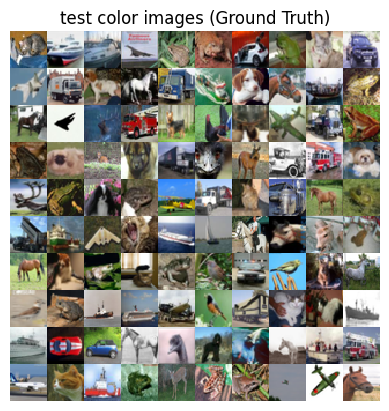

In [4]:
#input image dimesions
#we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]
#create saved_image folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)

if not os.path.isdir(save_dir):
       os.makedirs(save_dir)

imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('test color images (Ground Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [5]:
#convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)


In [6]:
#display grayscale version of test images

imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i)  for i in imgs])


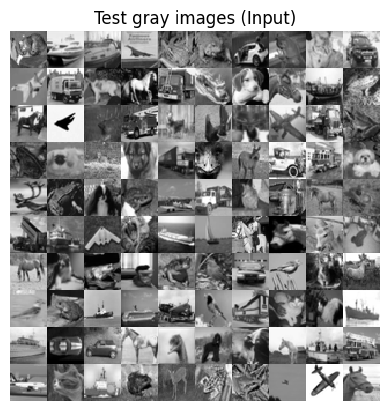

In [7]:
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

In [8]:
#Normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

In [10]:
#reshape images to row x col x channel for cnn output/validation}
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

In [11]:
#reshape images to row x col x chanel for cnn input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)

x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)


In [12]:
 #networks parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size=3
latent_dim = 256
#encoder/decoder number of cnn layer and filters per layer
layer_filters = [64, 128, 256]


In [13]:
#build the autoencoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
#stacks of conv2d(64)-conv2d(128)-conv2d(256)
for filters in layer_filters:
  x = Conv2D(filters=filters,
             kernel_size=kernel_size,
             strides=2, #Especifica los pasos de la operación de convolución.
             activation='relu',
             padding='same'
             )(x)

In [14]:
#shape info needed to build decoder model so we don't do hand computation
#the nput to decoder´s first Conv2DTrasnspose will have this shape
#shape  shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x) #vuelve la forma de un tensor como una tupla de enteros


In [15]:
#generated a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

#instance encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

In [16]:
#Build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3] ) (latent_inputs)
x = Reshape((shape[1], shape[2], shape[3])) (x)

In [17]:
#stack of Conv2DTranspose(256)-Conv2DTraspose(128)-Conv2DTraspose(64)

for filter in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 256)      5900

In [18]:
#autoencoder = encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)),name='Autoencoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 256)      5900

In [19]:
#prepare model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)



In [20]:
#reduce  learnig rate by sqrt(0.1) if the loss does not improve in 5 epchos

lr_reducer = ReduceLROnPlateau(
                                factor=np.sqrt(0.1),
                                cooldown=0,
                                patience=5,
                                verbose=1,
                                min_lr=0.5e-6
                               )

In [21]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True
                             )

In [22]:
autoencoder.compile(loss='mse', optimizer='adam')
callbacks = [lr_reducer, checkpoint]

In [23]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks
                 )

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0152
Epoch 1: val_loss improved from inf to 0.01061, saving model to /content/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 24s 7ms/step - loss: 0.0152 - val_loss: 0.0106 - lr: 0.0010
Epoch 2/30
1556/1563 [============================>.] - ETA: 0s - loss: 0.0101
Epoch 2: val_loss improved from 0.01061 to 0.00948, saving model to /content/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0101 - val_loss: 0.0095 - lr: 0.0010
Epoch 3/30
1558/1563 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 3: val_loss did not improve from 0.00948
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0091 - val_loss: 0.0095 - lr: 0.0010
Epoch 4/30
1557/1563 [============================>.] - ETA: 0s - loss: 0.0086
Epoch 4: val_loss improved from 0.00948 to 0.00838, saving model to /content/saved_models/colo

313/313 [==============================] - 1s 2ms/step


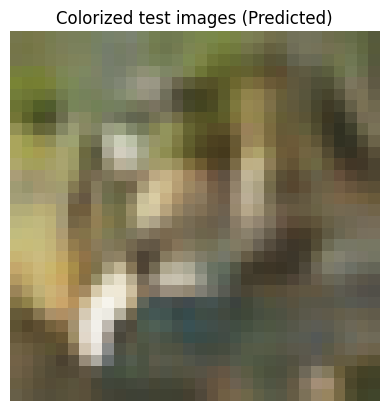

In [45]:
x_decoded = autoencoder.predict(x_test_gray)
imgs = x_decoded[:1]
imgs = imgs.reshape((1, 1, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()